In [12]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


In [13]:
data = pd.read_csv('orders.csv')
data.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item
0,2714054,469662,21386,2015-10-15 08:50:56.000,597982.0,محمود آباد,1.0
1,11104039,3063877,248497,2018-02-11 00:29:26.000,980000.0,خرمدره,1.0
2,4228130,3184893,50144,2016-06-14 00:30:08.000,229358.0,قرچک,1.0
3,22225624,6888562,70208,2018-09-03 14:37:19.000,16514.0,قم,1.0
4,4068771,2533490,67627,2016-05-21 11:51:02.000,133028.0,تهران,1.0


In [14]:
data['DayTime_CartFinalize'] = pd.to_datetime(data['DateTime_CartFinalize'], format='%Y-%m-%d')


In [15]:
data = data.loc[(data['DayTime_CartFinalize'] > '2016-12-30')
                     & (data['DayTime_CartFinalize'] < '2017-12-30')]


In [16]:
data.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item,DayTime_CartFinalize
6,8267421,5235886,42365,2017-08-19 13:30:24.000,55046.0,اصفهان,1.0,2017-08-19 13:30:24
8,9916301,1145709,102588,2017-12-11 19:33:59.000,34862.0,تهران,1.0,2017-12-11 19:33:59
15,7759076,3185842,376625,2017-07-05 09:37:45.000,708440.0,اصفهان,1.0,2017-07-05 09:37:45
17,9934875,2876902,140331,2017-12-13 11:28:20.000,717798.0,تنکابن,1.0,2017-12-13 11:28:20
20,6156363,3549803,193926,2017-01-24 03:05:35.000,41284.0,تهران,3.0,2017-01-24 03:05:35


In [17]:
LastDay = max(data['DayTime_CartFinalize'])
LastDay

Timestamp('2017-12-29 23:53:02')

In [18]:
min(data['DayTime_CartFinalize'])

Timestamp('2016-12-30 00:17:47')

In [19]:
data.shape

(60871, 8)

In [20]:
data_describe = data.filter(['Amount_Gross_Order', 'Quantity_item'])

In [21]:
data_describe.describe()

,Amount_Gross_Order,Quantity_item
count,6.087100e+04,60871.000000
mean,1.424590e+06,1.287592
std,7.466989e+06,1.411745
min,1.000000e+00,1.000000
25%,1.100920e+05,1.000000
50%,3.035780e+05,1.000000
75%,9.900000e+05,1.000000
max,1.530000e+09,85.000000


In [22]:
data_describe.corr()

,Amount_Gross_Order,Quantity_item
Amount_Gross_Order,1.000000,-0.027062
Quantity_item,-0.027062,1.000000


In [23]:
Recency = data.groupby('ID_Customer')['DayTime_CartFinalize'].apply( lambda x: (LastDay - x.max()).days)
Recency = Recency.reset_index()
Recency.head()

,ID_Customer,DayTime_CartFinalize
0,466132,161
1,466136,98
2,466141,291
3,466212,210
4,466226,295


In [24]:
Frequency = data.groupby('ID_Customer')['ID_Order'].count()
Frequency = Frequency.reset_index()
Frequency.head()

,ID_Customer,ID_Order
0,466132,2
1,466136,1
2,466141,2
3,466212,1
4,466226,1


In [25]:
RFM1 = pd.merge(Recency, Frequency, on='ID_Customer', how = 'inner' )
RFM1.head()

,ID_Customer,DayTime_CartFinalize,ID_Order
0,466132,161,2
1,466136,98,1
2,466141,291,2
3,466212,210,1
4,466226,295,1


In [26]:
Monetary = data.groupby('ID_Customer')['Amount_Gross_Order'].sum()
Monetary = Monetary.reset_index()
Monetary.head()

,ID_Customer,Amount_Gross_Order
0,466132,434495.0
1,466136,306963.0
2,466141,783028.0
3,466212,100000.0
4,466226,27523.0


In [27]:
RFM = pd.merge(RFM1, Monetary, on='ID_Customer', how = 'inner' )
RFM.head()

,ID_Customer,DayTime_CartFinalize,ID_Order,Amount_Gross_Order
0,466132,161,2,434495.0
1,466136,98,1,306963.0
2,466141,291,2,783028.0
3,466212,210,1,100000.0
4,466226,295,1,27523.0


In [28]:
RFM.columns = ['ID_Customer','Recency', 'Frequency', 'Monetary']
RFM.head()

,ID_Customer,Recency,Frequency,Monetary
0,466132,161,2,434495.0
1,466136,98,1,306963.0
2,466141,291,2,783028.0
3,466212,210,1,100000.0
4,466226,295,1,27523.0


In [29]:
rfm_df = RFM[['Recency', 'Frequency', 'Monetary']]

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,10))
rfm_N = scaler.fit_transform(rfm_df)

In [33]:
rfm_N

array([[4.98076923, 1.24324324, 1.00255576],
       [3.42307692, 1.        , 1.0018056 ],
       [8.19505495, 1.24324324, 1.00460588],
       ...,
       [1.        , 1.        , 1.05311583],
       [1.        , 1.        , 1.0035077 ],
       [1.        , 1.        , 1.01575768]])

In [34]:
rfm_df_scaled = pd.DataFrame(rfm_N)
rfm_df_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,4.980769,1.243243,1.002556
1,3.423077,1.000000,1.001806
2,8.195055,1.243243,1.004606
3,6.192308,1.000000,1.000588
4,8.293956,1.000000,1.000162


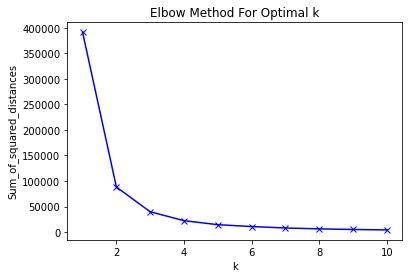

In [35]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rfm_df_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [36]:
km = KMeans(n_clusters= 6 ,init='k-means++', max_iter=300 )
km = km.fit(rfm_df_scaled)
km

KMeans(n_clusters=6)

In [37]:
km.labels_

array([3, 4, 5, ..., 1, 1, 1])

In [38]:
RFM['Cluster_Id'] = km.labels_
RFM.head()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
0,466132,161,2,434495.0,3
1,466136,98,1,306963.0,4
2,466141,291,2,783028.0,5
3,466212,210,1,100000.0,0
4,466226,295,1,27523.0,5


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

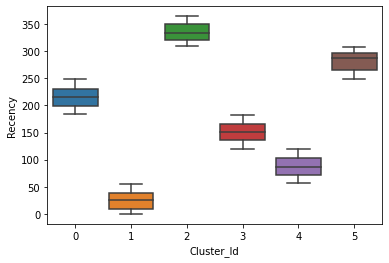

In [39]:
sns.boxplot(x='Cluster_Id', y='Recency', data=RFM)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

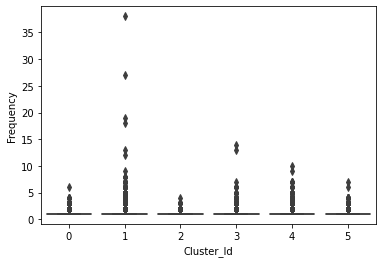

In [40]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=RFM)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

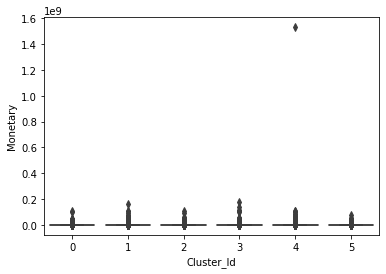

In [41]:
sns.boxplot(x='Cluster_Id', y='Monetary', data=RFM)


In [49]:
RFM.shape

(53018, 5)

In [50]:
RFM[RFM['Cluster_Id'] == 0].shape

(6743, 5)

In [51]:
RFM[RFM['Cluster_Id'] == 1].shape

(13413, 5)

In [52]:
RFM[RFM['Cluster_Id'] == 2].shape

(6388, 5)

In [53]:
RFM[RFM['Cluster_Id'] == 3].shape

(8173, 5)

In [54]:
RFM[RFM['Cluster_Id'] == 4].shape

(11133, 5)

In [55]:
RFM[RFM['Cluster_Id'] == 5].shape

(7168, 5)

In [56]:
RFM.describe()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
count,5.301800e+04,53018.000000,53018.000000,5.301800e+04,53018.000000
mean,2.974141e+06,153.909521,1.148120,1.635599e+06,2.472368
std,1.720442e+06,109.724812,0.539652,8.096552e+06,1.658172
min,4.661320e+05,0.000000,1.000000,1.000000e+00,0.000000
25%,1.158674e+06,55.000000,1.000000,1.376150e+05,1.000000
50%,3.199378e+06,135.000000,1.000000,3.830825e+05,2.000000
75%,4.409851e+06,251.000000,1.000000,1.224943e+06,4.000000
max,6.191168e+06,364.000000,38.000000,1.530052e+09,5.000000


In [57]:
RFM.corr()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
ID_Customer,1.000000,-0.141973,-0.085392,-0.004051,-0.037238
Recency,-0.141973,1.000000,-0.134252,0.003739,0.220283
Frequency,-0.085392,-0.134252,1.000000,0.083255,-0.033926
Monetary,-0.004051,0.003739,0.083255,1.000000,0.005929
Cluster_Id,-0.037238,0.220283,-0.033926,0.005929,1.000000


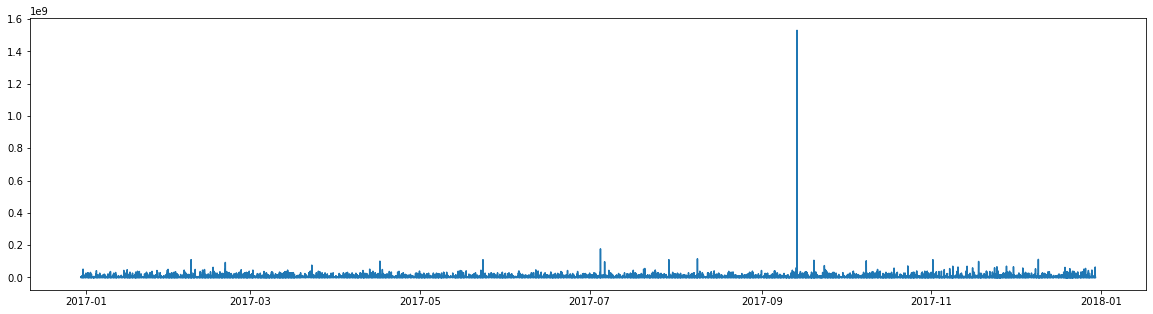

In [42]:
df_average_sales = data.groupby(by=['DayTime_CartFinalize'], as_index=False)['Amount_Gross_Order'].sum()
df_average_saless = df_average_sales.sort_values('Amount_Gross_Order', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales.DayTime_CartFinalize, df_average_sales.Amount_Gross_Order)
plt.show()

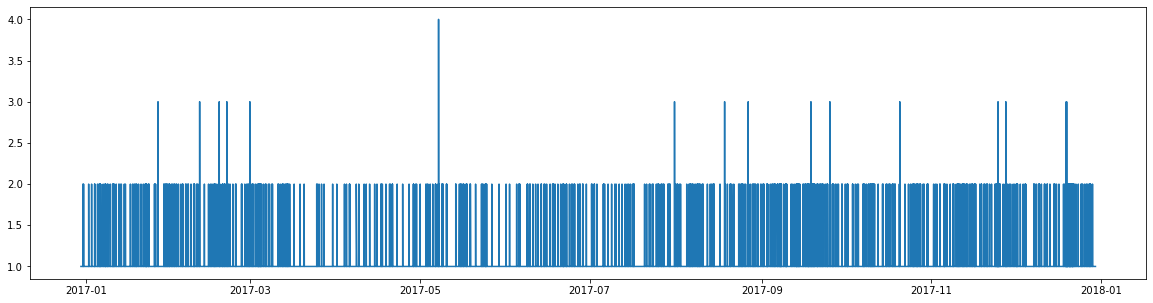

In [43]:
df_average_sales = data.groupby(by=['DayTime_CartFinalize'], as_index=False)['ID_Order'].count()
df_average_saless = df_average_sales.sort_values('ID_Order', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales.DayTime_CartFinalize, df_average_sales.ID_Order)
plt.show()

In [44]:
orders = data.filter(['city_name_fa', 'Quantity_item'])

In [45]:
groups = orders.groupby(by=['city_name_fa'], as_index=False)
groups.first()

,city_name_fa,Quantity_item
0,آب بر,1.0
1,آبادان,1.0
2,آباده,1.0
3,آبدانان,2.0
4,آبسرد,1.0
...,...,...
708,گوگان,1.0
709,گیلانغرب,2.0
710,گیوی,1.0
711,یاسوج,1.0


In [46]:
orders = groups.sum()
orders.head()

,city_name_fa,Quantity_item
0,آب بر,4.0
1,آبادان,136.0
2,آباده,15.0
3,آبدانان,15.0
4,آبسرد,4.0


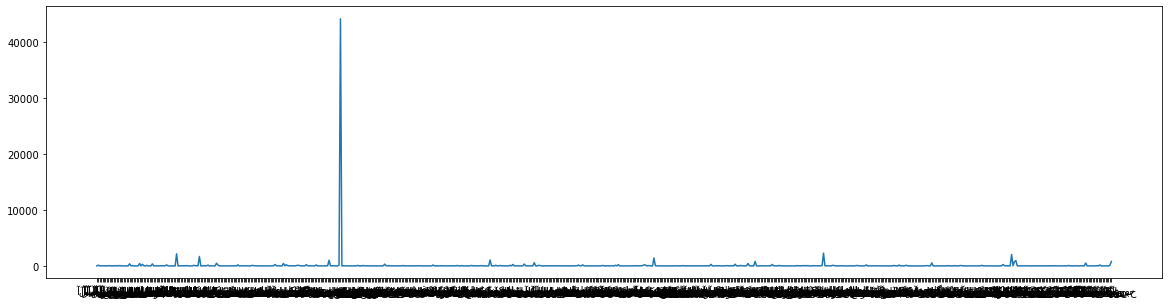

In [47]:
df_average_sales = orders.groupby(by=['city_name_fa'], as_index=False)['Quantity_item'].sum()
df_average_saless = df_average_sales.sort_values('Quantity_item', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales.city_name_fa, df_average_sales.Quantity_item)
plt.show()

In [48]:
orders[orders['Quantity_item'] == orders['Quantity_item'].max()]


,city_name_fa,Quantity_item
171,تهران,44127.0
